In [ ]:
import numpy as np
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
! pip install chainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import time
import math
import random
import copy
import torch
from sklearn.utils import shuffle
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode(connected=True)

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [ ]:
! pip install chainer
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('PL11_data_all_En.csv')
train.head()

In [ ]:
class Environment:
    
    def __init__(self, train, history_t=0):

        self.history_t = history_t
        self.data = train
        self.n_samples = train.shape[0]
        self.capacity =  torch.FloatTensor(train['Capacity'].values)
        self.states = torch.FloatTensor(train['PerEn3'].values)
        self.observation_space = torch.FloatTensor(train['PerEn3'].values) #.reshape(100,1)
        self.action_space = torch.FloatTensor(train['Capacity'].values)
        self.idx = 0
    
    def reset(self):
        self.idx = 0
        return self.states[self.idx].view(1, -1)
    
    def step(self, action):
      
        #profits = action/(df.iloc[0]['Capacity'])

        if action > 0.9:
          #print('Charge')
          reward = 1
        else:
          reward = 0
          #print('No Charge')

        self.idx += 1

        if self.idx >= self.n_samples:
            done = True
            self.idx = 0
        else:
            done = False

        return self.states[self.idx].view(1, -1), reward, done

env = Environment(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

In [ ]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.PReLU(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size),
                fc4 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            y = self.fc4(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=2)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 500
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.randint(2)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            print('Epoch:{}     step:{}     reward:{}     loss:{}'.format(epoch+1,total_step,log_reward,log_loss))
            start = time.time()
            
    return Q, total_losses, total_rewards, target, q

In [ ]:
Q, total_losses, total_rewards, target, q = train_dqn(Environment(train))

In [ ]:
def plot_loss_reward(total_losses, total_rewards):

    fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (12,6))
    axes[0].plot(total_rewards)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Reward')
    #axes[0].set_ylim([-5, np.max([total_rewards,total_losses])+5])
    axes[1].plot(total_losses)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_ylim([-5, np.max([total_rewards,total_losses])+5])

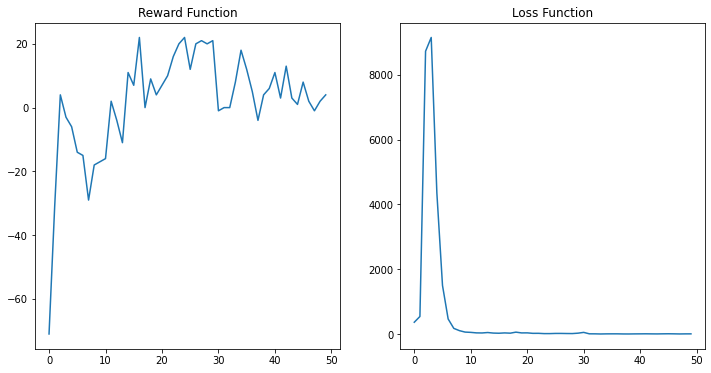

In [ ]:
plot_loss_reward(total_losses, total_rewards)

In [ ]:
from sklearn import metrics
q = chainer.as_array(q)
print('MAE : ' , metrics.mean_absolute_error(target,q))
print('MSE : ' , metrics.mean_squared_error(target,q))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(target,q)))